In [1]:
import preprocessing
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from xgboost import plot_importance


In [73]:
# Load file 
df = pd.read_excel('Data/new_acpc_newTotal.xlsx')

# Load file from preprocessing
df = preprocessing.main()
df.describe()

In [74]:
new_name = {'type': 'dystonia type',
            'tip_x': 'electrode tip (x)',
            'tip_y': 'electrode tip (y)',
            'tip_z': 'electrode tip (z)',
            'contact_x': 'active contact (x)',
            'contact_y': 'active contact (y)',
            'contact_z': 'active contact (z)',
}


In [75]:
df.rename(columns=new_name, inplace=True)

features = df.iloc[:,:-1]
target = df.iloc[:,-1]

In [69]:
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2
                                                    , random_state=42)
ct = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),  
    (OrdinalEncoder(categories='auto'), make_column_selector(dtype_include=object)))  
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test) #= ct.fit_transform(X_train)
X = ct.fit_transform(X)
print(X_train.shape)
print(X_test.shape)

# features

(136, 10)
(34, 10)


Performing GridSearchCV for Lasso Regression...
Fitting 10 folds for each of 24 candidates, totalling 240 fits


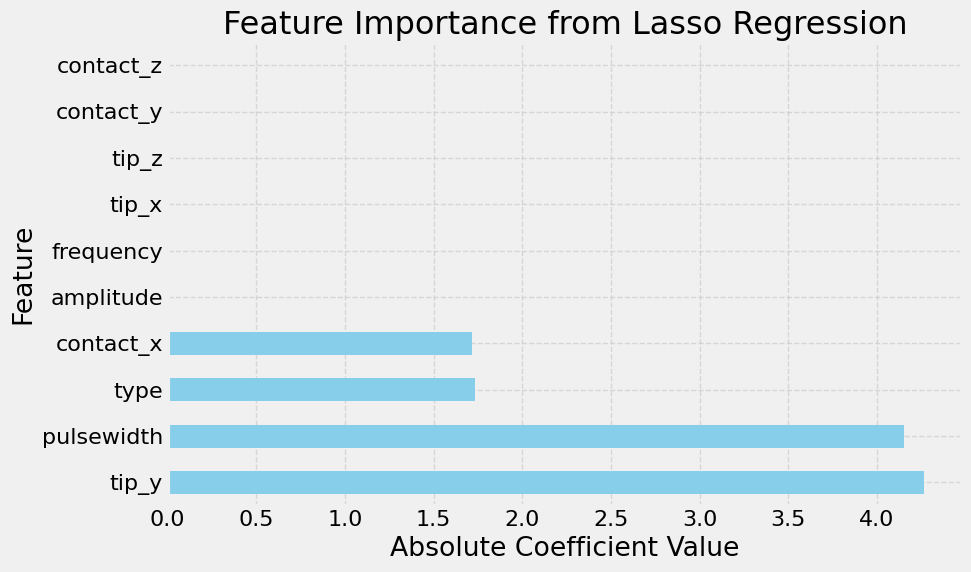

Performing GridSearchCV for Ridge...
Fitting 10 folds for each of 7 candidates, totalling 70 fits


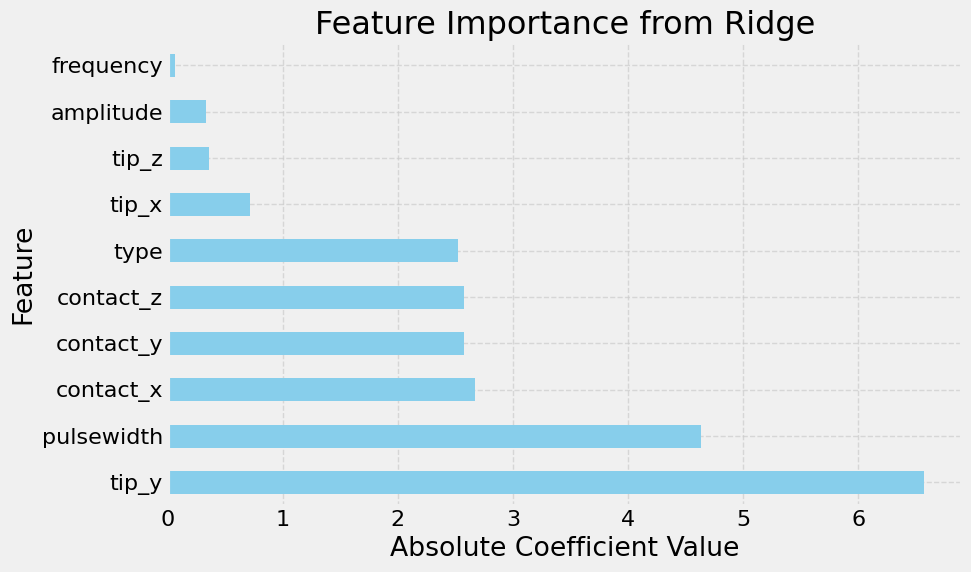

Performing GridSearchCV for SVR...
Fitting 10 folds for each of 224 candidates, totalling 2240 fits


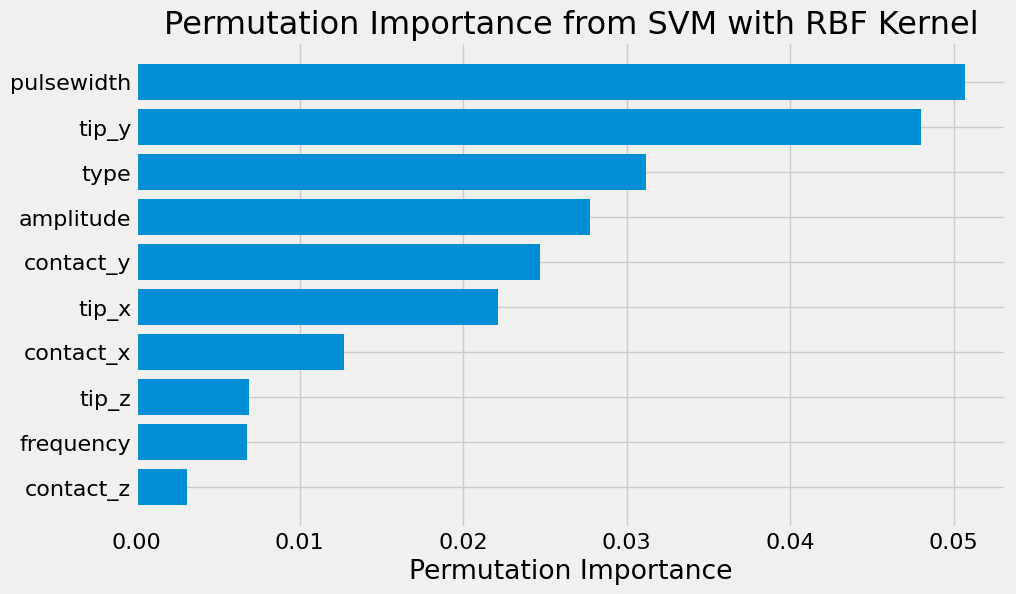

Performing GridSearchCV for Random Forest...
Fitting 10 folds for each of 6 candidates, totalling 60 fits


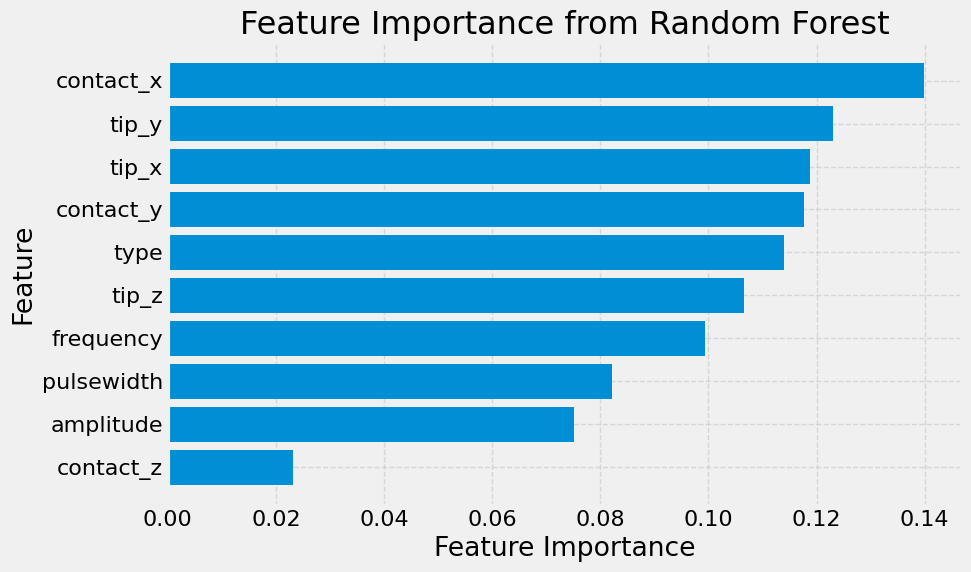

Performing GridSearchCV for xgboost...
Fitting 10 folds for each of 75 candidates, totalling 750 fits


<Figure size 1000x600 with 0 Axes>

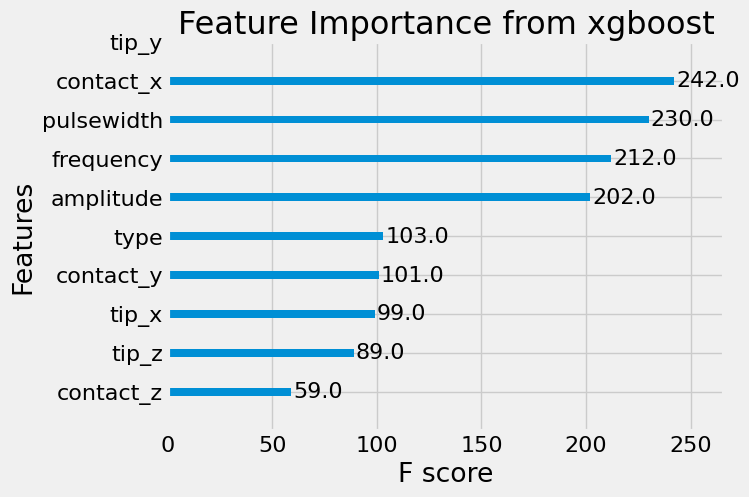

In [13]:
models = {
    'Lasso Regression': Lasso,
    'Ridge': Ridge,
    'SVR': SVR ,
    'Random Forest': RandomForestRegressor,
    'xgboost': xgb.XGBRegressor
}

# Define hyperparameters for each 
parameters = {
    'Lasso Regression': {
        'alpha': [0.001, 0.01, 0.1, 1.0],
        'max_iter': [1000, 2000, 3000],
        'selection': ['cyclic', 'random']
    },

    'Ridge': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 2.5, 4, 10.0]
    },
    
    'SVR': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.2, 0.5, 1, 1.4, 10],
        'gamma': ['scale', 'auto']
    },
    
    'Random Forest': {
        'n_estimators': [50, 100],  # , 200, 300
        'max_depth': [None, 10, 20],  #, 30
        'max_features': [1]  #, 'sqrt', 'log2'
    },

    'xgboost': {
        "max_depth":    [2,3, 4, 5, 6],
        "n_estimators": [500, 600, 700, 750, 800],
        "learning_rate": [0.01, 0.015, 0.02]
    }


}

kfold_split = KFold(n_splits=10, shuffle=True, random_state=500)  #, random_state=520
kfold_split.get_n_splits(X)

for model_name, model in models.items():
    print(f"Performing GridSearchCV for {model_name}...")
    
    # Create GridSearchCV instance
    grid_search = GridSearchCV(estimator=model(), param_grid=parameters[model_name], cv=kfold_split, scoring='neg_mean_squared_error', n_jobs=-1, verbose =4, return_train_score=True)
    grid_search.fit(X, y)
    best_model = model(**grid_search.best_params_)
    best_model.fit(X, y)

    # Plotting feature importance for specific models that support it
    if model_name in ['Lasso Regression', 'Ridge']:
        coefs = pd.Series(best_model.coef_, index=features.columns)
        sorted_coefs = coefs.abs().sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        sorted_coefs.plot(kind='barh', color='skyblue')
        plt.xlabel('Absolute Coefficient Value')
        plt.ylabel('Feature')
        plt.title(f'Feature Importance from {model_name}')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    elif model_name == 'SVR':
        if best_model.kernel == 'linear':
            svm_coefs = pd.Series(best_model.coef_[0], index=features.columns)
            sorted_svm_coefs = svm_coefs.abs().sort_values(ascending=False)
            plt.figure(figsize=(10, 6))
            sorted_svm_coefs.plot(kind='barh')
            plt.title('Feature Importance from SVM with RBF Kernel')
            plt.show()
        else:
            # Fit the SVM model
            result = permutation_importance(best_model, X, y, n_repeats=10, random_state=42)
            importance = result.importances_mean
            plt.figure(figsize=(10, 6))
            sorted_idx = importance.argsort()
            plt.barh(features.columns[sorted_idx], importance[sorted_idx])
            plt.xlabel("Permutation Importance")
            plt.title("Permutation Importance from SVM with RBF Kernel")
            plt.show()
    elif model_name == 'Random Forest':
        importances = best_model.feature_importances_
        sorted_idx = importances.argsort()
        plt.figure(figsize=(10, 6))
        plt.barh(features.columns[sorted_idx][-10:], importances[sorted_idx][-10:])
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title(f'Feature Importance from {model_name}')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    elif model_name == 'xgboost':
        plt.figure(figsize=(10, 6))
        plt.style.use('fivethirtyeight')
        plt.rcParams.update({'font.size': 16})
        plot_importance(best_model, max_num_features=10)
        # Get feature importances
        importances = best_model.feature_importances_
        sorted_idx = importances.argsort()
        top_features = sorted_idx[-10:]
        feature_names = features.columns 
        top_feature_names = feature_names[top_features]
        plt.yticks(range(len(top_feature_names)), top_feature_names)  
        plt.title(f'Feature Importance from {model_name}')
        plt.show()
    else:
        print(f"Feature importance plot is not available for {model_name}.")

    
    

Performing GridSearchCV for Lasso Regression...
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Performing GridSearchCV for Ridge...
Fitting 10 folds for each of 7 candidates, totalling 70 fits


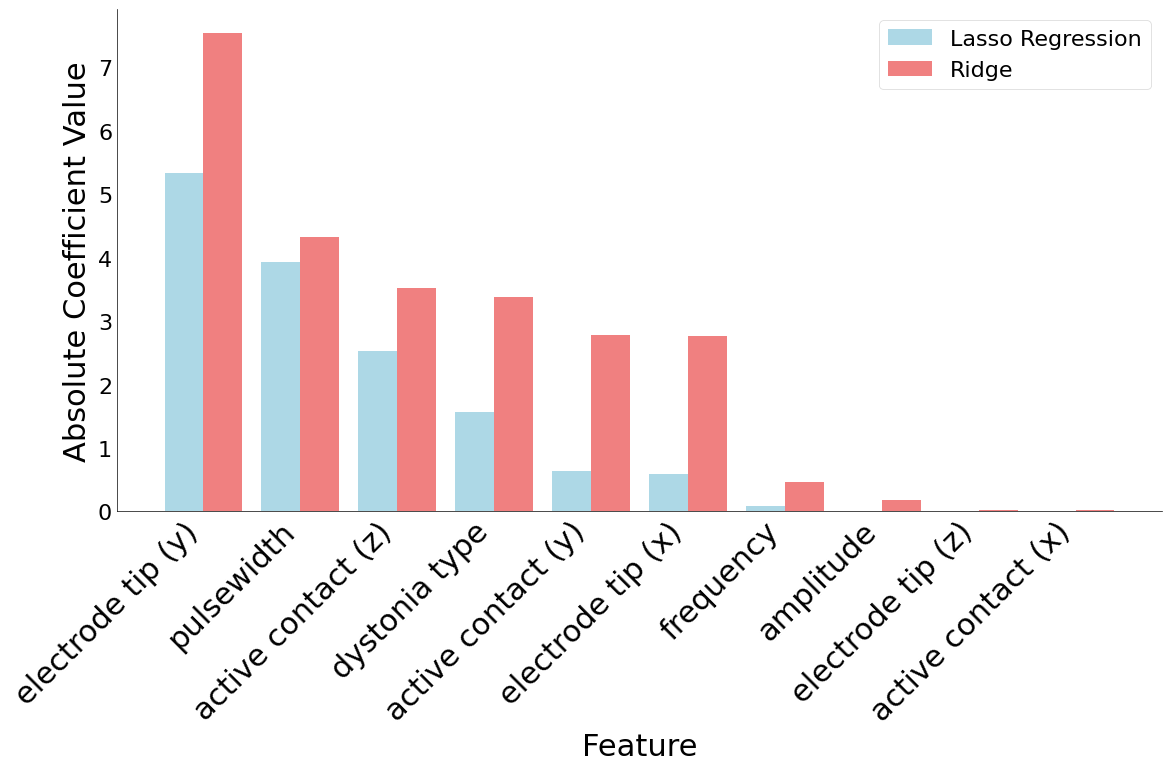

In [84]:
# Create a single subplot with a white background
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor('white')
ax.set_facecolor('white')

bar_width = 0.4
bar_positions = np.arange(len(features.columns))

paler_colors = ['lightblue', 'lightcoral']
kfold_split = KFold(n_splits=10, shuffle=True, random_state=500)  #, random_state=520
kfold_split.get_n_splits(X)
for i, (model_name, model_color) in enumerate(zip(['Lasso Regression', 'Ridge'], paler_colors)):
    print(f"Performing GridSearchCV for {model_name}...")
    
    # Create GridSearchCV instance
    grid_search = GridSearchCV(estimator=models[model_name](), param_grid=parameters[model_name], cv=kfold_split, scoring='neg_mean_squared_error', n_jobs=-1, verbose=4, return_train_score=True)
    grid_search.fit(X, y)
    best_model = models[model_name](**grid_search.best_params_)
    best_model.fit(X, y)

    # Plotting feature importance for specific models that support it
    coefs = pd.Series(best_model.coef_, index=features.columns)
    sorted_coefs = coefs.abs().sort_values(ascending=False)

    sorted_feature_names = sorted_coefs.index
    sorted_coefficients = sorted_coefs.values
    
    # Plot grouped bar chart
    # bars = ax.bar(bar_positions + i * bar_width, sorted_coefs, bar_width, color=model_color, label=model_name)
    bars = ax.bar(bar_positions + i * bar_width, sorted_coefficients, bar_width, color=model_color, label=model_name)

    # Set label colors to white
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_color('black')

    for label in ax.legend().get_texts():
        label.set_color('black')
        label.set_fontsize(22)

ax.set_xlabel('Feature', color='black', size=22)
ax.set_ylabel('Absolute Coefficient Value', color='black', size=22)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')#.set_linewidth(2)
ax.spines['left'].set_color('black')#.set_linewidth(2)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
# ax.set_title('Grouped Feature Importance Comparison (Lasso vs Ridge)', color='white')
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(sorted_feature_names, rotation=45, ha='right', size=22)
ax.legend(facecolor='white')
ax.grid(False)  # Remove the grid
plt.tight_layout()
plt.show()

In [80]:
sorted_feature_names = sorted_coefs.index
sorted_coefficients = sorted_coefs.values
sorted_coefficients = sorted_coefficients.tolist()
print(sorted_coefficients )
print(sorted_feature_names)

[7.543011378275902, 4.322614482108395, 3.51704336363664, 3.3817979370331765, 2.786293267396131, 2.768420845044419, 0.4712058791600435, 0.17858827101936792, 0.027319353567634465, 0.021963440565180636]
Index(['electrode tip (y)', 'pulsewidth', 'active contact (z)',
       'dystonia type', 'active contact (y)', 'electrode tip (x)', 'frequency',
       'amplitude', 'electrode tip (z)', 'active contact (x)'],
      dtype='object')


Performing GridSearchCV for Lasso Regression...
Fitting 10 folds for each of 24 candidates, totalling 240 fits


Performing GridSearchCV for Ridge...
Fitting 10 folds for each of 7 candidates, totalling 70 fits


<Figure size 1200x800 with 0 Axes>

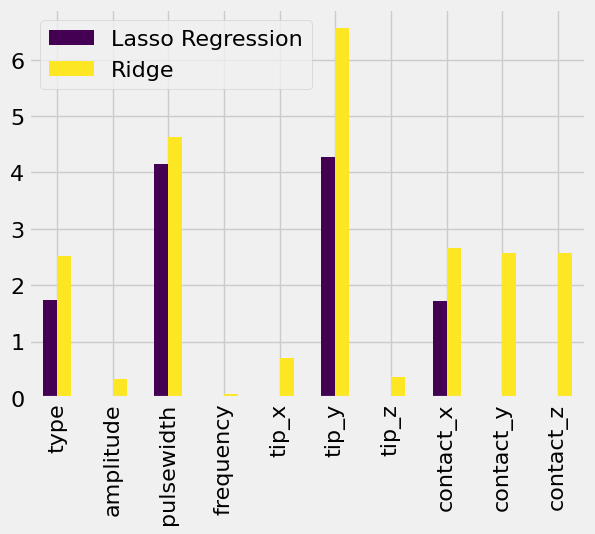

In [35]:
coef_df = pd.DataFrame(index=features.columns)


for i, (model_name, model_color) in enumerate(zip(['Lasso Regression', 'Ridge'], paler_colors)):
    print(f"Performing GridSearchCV for {model_name}...")
    
    # Create GridSearchCV instance
    grid_search = GridSearchCV(estimator=models[model_name](), param_grid=parameters[model_name], cv=kfold_split, scoring='neg_mean_squared_error', n_jobs=-1, verbose=4, return_train_score=True)
    grid_search.fit(X, y)
    best_model = models[model_name](**grid_search.best_params_)
    best_model.fit(X, y)

    # Store coefficients in the DataFrame
    coef_df[model_name] = best_model.coef_
# Plotting grouped bar chart
plt.figure(figsize=(12, 8))
coef_df.abs().plot(kind='bar', colormap='viridis')
# plt.xlabel('Feature')
# plt.ylabel('Absolute Coefficient Value')
# plt.title('Feature Importance from Lasso and Ridge Regression')
# # plt.grid(True, linestyle='--', alpha=0.7)
# # plt.legend(title='Model')
# plt.tight_layout()
plt.show()

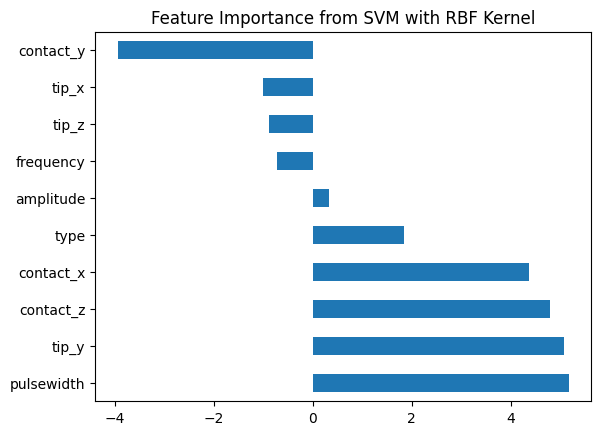

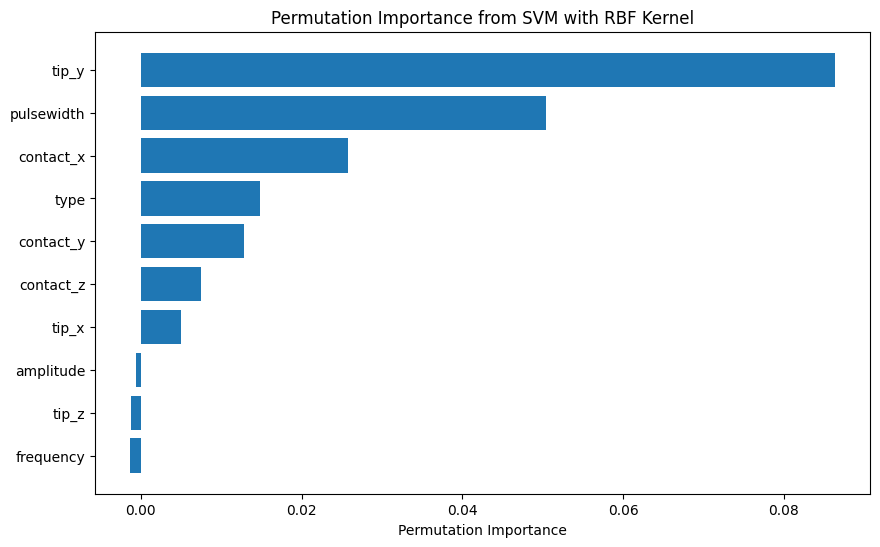

In [44]:
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

svm_rbf = SVR(kernel='linear')  # You can use different kernels like 'linear', 'poly', 'sigmoid', etc.
svm_rbf.fit(X, y)
svm_coefs = pd.Series(svm_rbf.coef_[0], index=features.columns)
sorted_svm_coefs = svm_coefs.sort_values(ascending=False)
sorted_svm_coefs.plot(kind='barh')
plt.title('Feature Importance from SVM with RBF Kernel')
plt.show()



# Fit the SVM model
svm_rbf.fit(X, y)

# Calculate permutation importance
result = permutation_importance(svm_rbf, X, y, n_repeats=10, random_state=42)

# Get the importance scores
importance = result.importances_mean

# Plot the feature importance
plt.figure(figsize=(10, 6))
sorted_idx = importance.argsort()
plt.barh(features.columns[sorted_idx], importance[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance from SVM with RBF Kernel")
plt.show()

